In [28]:
from scipy.interpolate import RegularGridInterpolator
# from skimage import io, img_as_ubyte
import cv2, os, re
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [2]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
def open_image(path:'str'):
    assert os.path.exists(path)

    img = cv2.imread(path, 0)  # As gray
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128)) # img
    return img

In [4]:
input_image = []
# Concat images to depth
apical_paths = sorted(os.listdir('data/synthetic/Segmentation/apical'), key=lambda x: (int(re.sub('\D','',x)), x))
for path in apical_paths:
    path = os.path.join('data/synthetic/Segmentation/apical', path)
    input_image.append(open_image(path))

input_image = np.array(input_image)
input_image.shape

(50, 128, 128)

In [5]:

pixelsize_old = 1
slice_thickness_old = 20

pixelsize_new = 1
slice_thickness_new = 10

In [6]:

x_old = np.linspace(0, (input_image.shape[1]-1)*pixelsize_old, input_image.shape[1])
y_old = np.linspace(0, (input_image.shape[2]-1)*pixelsize_old, input_image.shape[2])
z_old = np.arange(0, (input_image.shape[0]))*slice_thickness_old

In [7]:
print(x_old)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127.]


In [8]:
print(z_old)

[  0  20  40  60  80 100 120 140 160 180 200 220 240 260 280 300 320 340
 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700
 720 740 760 780 800 820 840 860 880 900 920 940 960 980]


In [9]:
method = "linear"  #   "linear"  "cubic"

my_interpolating_object = RegularGridInterpolator((z_old, x_old, y_old), input_image, method=method, bounds_error=False)

In [10]:
x_new = np.round(input_image.shape[1]*pixelsize_old/pixelsize_new).astype('int')
y_new = np.round(input_image.shape[2]*pixelsize_old/pixelsize_new).astype('int')
z_new = np.arange(z_old[0], z_old[-1], slice_thickness_new)

In [11]:
# pts is the new grid
pts = np.indices((len(z_new), x_new, y_new)).transpose((1, 2, 3, 0))
pts = pts.reshape(1, len(z_new)*x_new*y_new, 1, 3).reshape(len(z_new)*x_new*y_new, 3)
pts = np.array(pts, dtype=float)
pts[:, 1:3] = pts[:, 1:3]*pixelsize_new
pts[:, 0] = pts[:, 0]*slice_thickness_new +z_new[0]

In [12]:
pts.shape

(1605632, 3)

In [13]:
print("Total z slices = ", pts.shape[0]/(input_image.shape[1]*input_image.shape[2]))

Total z slices =  98.0


In [14]:
# Interpolate
interpolated_data = my_interpolating_object(pts)
interpolated_data = interpolated_data.reshape(len(z_new), x_new, y_new)

interpolated_data.shape

(98, 128, 128)

In [15]:
interpolated_data_16bit = (np.round(((interpolated_data - interpolated_data.min())/(interpolated_data.max() - interpolated_data.min())) * 255.0)).astype(np.uint8)

In [16]:
# interpolated_data_16bit.tolist()

In [17]:
import imageio


fps = 5
# imageio.mimsave('results/interpolation_apical.gif', interpolated_data_16bit, format='GIF', fps=fps)  # .tolist()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid

ellipsoid : (M, N, P) array

Ellipsoid centered in a correctly sized array for given spacing. Boolean dtype unless levelset=True, in which case a float array is returned with the level set above 0.0 representing the ellipsoid.

In [19]:
interpolated_data_16bit.shape

(98, 128, 128)

In [20]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(interpolated_data_16bit, 0)

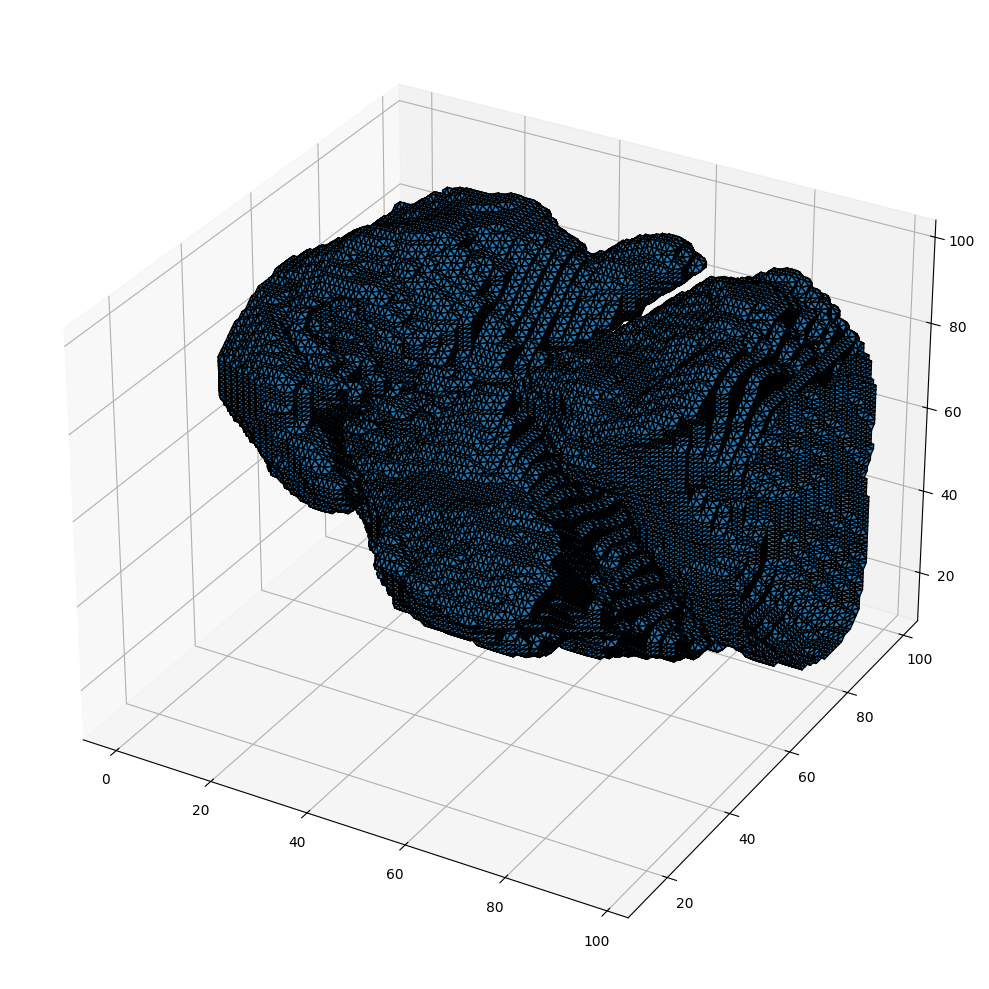

In [21]:
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

plt.tight_layout()
plt.show()

In [6]:
from notebooks.utils import interpolate

In [23]:
# input_image = []
# # Concat images to depth
# apical_paths = sorted(os.listdir('data/synthetic/Segmentation/apical'), key=lambda x: (int(re.sub('\D','',x)), x))
# l_parasternal_paths = sorted(os.listdir('data/synthetic/Segmentation/left_parasternal'), key=lambda x: (int(re.sub('\D','',x)), x))
# for path in l_parasternal_paths:
#     path = os.path.join('data/synthetic/Segmentation/left_parasternal', path)
#     input_image.append(open_image(path))

# input_image = np.array(input_image)
# input_image.shape

In [24]:
# verts, faces, normals, values = interpolate(input_image)

In [25]:
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# # Fancy indexing: `verts[faces]` to generate a collection of triangles
# mesh = Poly3DCollection(verts[faces])
# mesh.set_edgecolor('k')
# ax.add_collection3d(mesh)

# plt.tight_layout()
# plt.show()

3


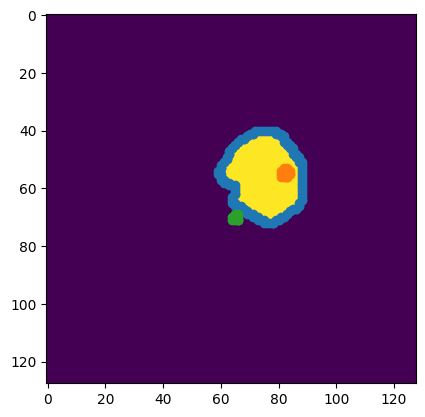

In [26]:
# Find contours at a constant value of 0.8
contours = measure.find_contours(interpolated_data_16bit[0], 0.8)
print(len(contours))

plt.imshow(interpolated_data_16bit[0])
for contur in contours:
    contur = contur.astype(int)
    plt.scatter(contur[:, 1], contur[:, 0])

In [27]:
# def write_image_at_angle(source, target, angle):
#     # rotate a single image around y-axis and store it
#     # in the target 3D stack
#     temp = cle.create_like(target)
        
#     transform = cle.AffineTransform3D()
#     transform.center(source.shape)
#     transform.rotate_around_y_axis(-angle)
#     transform.center(target.shape, undo=True)
    
#     cle.affine_transform(source, temp, transform=transform)
    
#     cle.maximum_images(target, temp, target)
    
#     return target

In [28]:
# def create_stack_from_angular_images(raw_stack, target):
#     # Write images and multiple angles in to target stack
#     demo = []
#     for angle, image in raw_stack.items():
#         write_image_at_angle(image, target, angle)

#         demo.append(target[:,128,:])
    
#     demo2 = np.asarray(demo).astype(np.uint8)
#     imsave_animated_gif("demo_4.gif", demo2, meta={})

In [29]:
# from vedo import np, load, merge, show

# pics = load('results/subcostal_20.gif')

# meshes = []
# for i, p in enumerate(pics):
#     m = p.tomesh().wireframe()
#     m.shift(-128,-128,0).rotateX(90).rotateZ(360*i/len(pics))
#     meshes.append(m)
# pcloud = merge(meshes).subsample(0.01)

# rgb = pcloud.pointdata['RGBA']
# scalar = np.sum(rgb, axis=1).astype(float) / (255*3)
# pcloud.pointdata['intensity'] = scalar
# pcloud.pointdata.select('intensity')
# pcloud.pointdata.remove("Normals")
# pcloud.pointdata.remove("TextureCoordinates")
# pcloud.print()

# vol = pcloud.tovolume(kernel='shepard', N=2, dims=(150,150,150))
# vslice = vol.slicePlane(origin=vol.center(), normal=(0,0,1))
# vslice.cmap("bone_r").lighting('off')

# show([meshes, vol, vslice], N=3, axes=1).close()

In [30]:
import cv2
import math
import numpy as np
import os


# creates a point cloud file (.ply) from numpy array
def createPointCloud(filename, arr):
    # open file and write boilerplate header
    file = open(filename, 'w');
    file.write("ply\n");
    file.write("format ascii 1.0\n");

    # count number of vertices
    num_verts = arr.shape[0];
    file.write("element vertex " + str(num_verts) + "\n");
    file.write("property float32 x\n");
    file.write("property float32 y\n");
    file.write("property float32 z\n");
    file.write("end_header\n");

    # write points
    point_count = 0;
    for point in arr:
        # progress check
        point_count += 1;
        if point_count % 1000 == 0:
            print("Point: " + str(point_count) + " of " + str(len(arr)));

        # create file string
        out_str = "";
        for axis in point:
            out_str += str(axis) + " ";
        out_str = out_str[:-1]; # dump the extra space
        out_str += "\n";
        file.write(out_str);
    file.close();


# extracts points from mask and adds to list
def addPoints(mask, points_list, depth):
    mask_points = np.where(mask == 255);
    for ind in range(len(mask_points[0])):
        # get point
        x = mask_points[1][ind];
        y = mask_points[0][ind];
        point = [x,y,depth];
        points_list.append(point);

def main():
    # tweakables
    slice_thickness = 2; # distance between slices
    xy_scale = 1 ; # rescale of xy distance

    # load images 
    folder = 'data/synthetic/Segmentation/apical'
    files = os.listdir(folder);
    # images = [];
    # for file in files:
    #     if file[-4:] == ".tif":
    #         img = cv2.imread(folder + file, cv2.IMREAD_GRAYSCALE);
    #         img = cv2.resize(img, (100, 100)); # change here for more or less resolution
    #         images.append(img);

    # images = input_image.copy()
    images = interpolated_data_16bit.copy()
    # keep a blank mask
    blank_mask = np.zeros_like(images[0], np.uint8);

    # create masks
    masks = [];
    masks.append(blank_mask);
    for image in images:
        # mask
        mask = cv2.inRange(image, 50, 255);

        # show
        # cv2.imshow("Mask", mask);
        # cv2.waitKey(1);
        masks.append(mask);
    masks.append(blank_mask);
    # cv2.destroyAllWindows();

    # go through and get points
    depth = 0;
    points = [];
    for index in range(1,len(masks)-1):
        # progress check
        print("Index: " + str(index) + " of " + str(len(masks)));

        # get three masks
        prev = masks[index - 1];
        curr = masks[index];
        after = masks[index + 1];

        # do a slice on previous
        prev_mask = np.zeros_like(curr);
        prev_mask[prev == 0] = curr[prev == 0];
        addPoints(prev_mask, points, depth);

        # # do a slice on after
        next_mask = np.zeros_like(curr);
        next_mask[after == 0] = curr[after == 0];
        addPoints(next_mask, points, depth);

        # get contour points (_, contours) in OpenCV 2.* or 4.*
        contours, _ = cv2.findContours(curr, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE);
        for con in contours:
            for point in con:
                p = point[0]; # contours have an extra layer of brackets
                points.append([p[0], p[1], depth]);

        # increment depth
        depth += slice_thickness;

    # rescale x,y points
    for ind in range(len(points)):
        # unpack
        x,y,z = points[ind];

        # scale
        x *= xy_scale;
        y *= xy_scale;
        points[ind] = [x,y,z];

    # convert points to numpy and dump duplicates
    points = np.array(points).astype(np.float32);
    points = np.unique(points.reshape(-1, points.shape[-1]), axis=0);
    print(points.shape);

    # save to point cloud file
    createPointCloud("results/test.ply", points);3

if __name__ == "__main__":
    main();

Index: 1 of 100
Index: 2 of 100
Index: 3 of 100
Index: 4 of 100
Index: 5 of 100
Index: 6 of 100
Index: 7 of 100
Index: 8 of 100
Index: 9 of 100
Index: 10 of 100
Index: 11 of 100
Index: 12 of 100
Index: 13 of 100
Index: 14 of 100
Index: 15 of 100
Index: 16 of 100
Index: 17 of 100
Index: 18 of 100
Index: 19 of 100
Index: 20 of 100
Index: 21 of 100
Index: 22 of 100
Index: 23 of 100
Index: 24 of 100
Index: 25 of 100
Index: 26 of 100
Index: 27 of 100
Index: 28 of 100
Index: 29 of 100
Index: 30 of 100
Index: 31 of 100
Index: 32 of 100
Index: 33 of 100
Index: 34 of 100
Index: 35 of 100
Index: 36 of 100
Index: 37 of 100
Index: 38 of 100
Index: 39 of 100
Index: 40 of 100
Index: 41 of 100
Index: 42 of 100
Index: 43 of 100
Index: 44 of 100
Index: 45 of 100
Index: 46 of 100
Index: 47 of 100
Index: 48 of 100
Index: 49 of 100
Index: 50 of 100
Index: 51 of 100
Index: 52 of 100
Index: 53 of 100
Index: 54 of 100
Index: 55 of 100
Index: 56 of 100
Index: 57 of 100
Index: 58 of 100
Index: 59 of 100
Index:

In [41]:
with open('/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction/data/synthetic/Segmentation/apical/angles.pkl', 'rb') as f:  # (f'data/synthetic/Segmentation/{name}/angles.pkl', 'rb') as f:
    x = pickle.load(f)

x

{'apical_-12.png': (-0.20943951023931956, -0.0, 1.1071487177940904),
 'apical_-8.png': (-0.13962634015954636, -0.0, 1.1071487177940904),
 'apical_-4.png': (-0.06981317007977318, -0.0, 1.1071487177940904),
 'apical_0.png': (0.0, -0.0, 1.1071487177940904),
 'apical_4.png': (0.06981317007977318, -0.0, 1.1071487177940904),
 'apical_8.png': (0.13962634015954636, -0.0, 1.1071487177940904),
 'apical_12.png': (0.20943951023931956, -0.0, 1.1071487177940904)}

In [42]:
np.rad2deg(1.107148), np.rad2deg(2.976) 

(np.float64(63.434907696350066), np.float64(170.512239830933))

In [43]:
positions_name = [
    'suprasternal', 
    'left_parasternal', 
    'apical', 
    'subcostal'
]
name = "apical"  # "suprasternal"
input_image = []
# Concat images to depth
# suprasternal_paths = sorted(os.listdir('data/synthetic/Segmentation/suprasternal'), key=lambda x: (int(re.sub('\D','',x)), x))
paths = [os.path.join(f'data/synthetic/Segmentation/{name}', f'{name}_{i}.png') for i in range(-12, 13, 4)]
for path in paths:
    # path = os.path.join('data/synthetic/Segmentation/suprasternal', path)
    input_image.append(open_image(path))

input_image = np.array(input_image)
input_image.shape

(7, 128, 128)

In [44]:
np.unique(input_image[0])

array([  0,  21,  43,  64,  85, 128, 170, 191, 213, 234, 255], dtype=uint8)

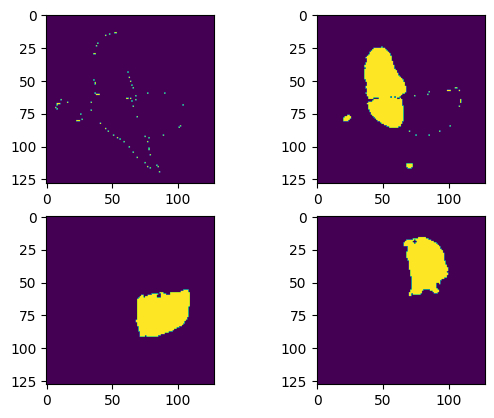

In [47]:
plt.subplot(221)
plt.imshow(np.where((input_image[0] > 10) & (input_image[0] < 64), 255, 0))
plt.subplot(222)
plt.imshow(np.where((input_image[0] > 64) & (input_image[0] < 128), 255, 0))
plt.subplot(223)
plt.imshow(np.where((input_image[0] > 128) & (input_image[0] < 191), 255, 0))
plt.subplot(224)
plt.imshow(np.where(input_image[0] > 191, 255, 0));

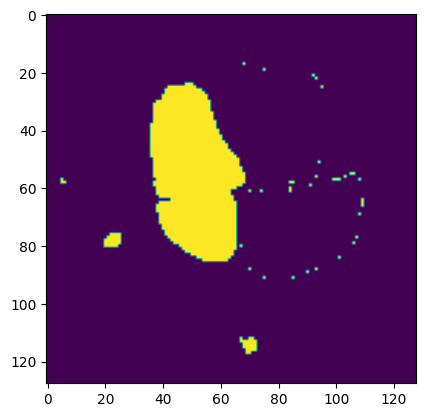

In [52]:
plt.imshow(np.where((input_image[0] > 0) & (input_image[0] < 86), 255, 0))

In [26]:
verts, faces, normals, values = interpolate(input_image)

AttributeError: 'list' object has no attribute 'shape'

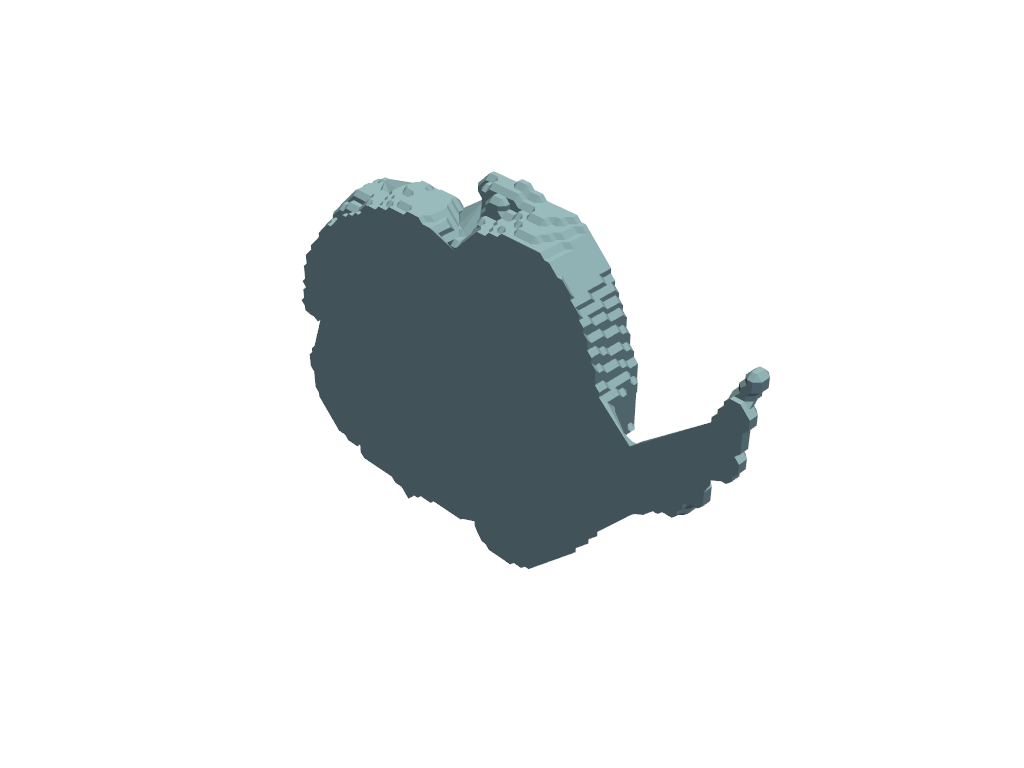

In [24]:
import pymeshfix
import pyvista as pv

# # Create object from vertex and face arrays
meshfix = pymeshfix.MeshFix(verts, faces)

# Plot input
# meshfix.plot()

# Repair input mesh
meshfix.repair()

# Access the repaired mesh with vtk
mesh = meshfix.mesh

# Or, access the resulting arrays directly from the object
meshfix.v # numpy np.float64 array
meshfix.f # numpy np.int32 array

# View the repaired mesh (requires vtkInterface)
meshfix.plot()

# Save the mesh
meshfix.save(f'results/{name}.ply')

# Try for LV, RV, RA separatly

## TODO: Smooth mesh

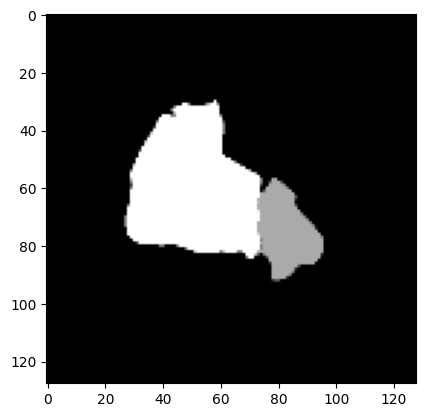

In [36]:
plt.imshow(input_image[21], 'gray');

In [37]:
np.unique(input_image)

array([  0,  21,  43,  64,  85, 106, 128, 149, 170, 191, 213, 234, 255],
      dtype=uint8)

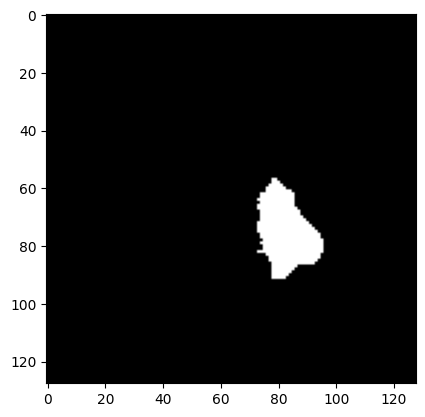

In [59]:
plt.imshow(np.where(
    (input_image[21] < 180) & (input_image[21] > 128), 255, 0), 'gray')

In [60]:
k = np.array([-6, 1, 4])

x = np.array([1, 1, 1])  # take a random vector
x -= x.dot(k) * k       # make it orthogonal to k
# x /= np.linalg.norm(x)

y = np.cross(k, x)      # cross product with k
y

array([-3, 10, -7])

In [57]:
def get_vw(u):
    # Make a permutation of the indices so that the least value is always "a"
    i = np.argmin(np.abs(u))
    a, b, c = np.roll(u.copy(), -i)
    
    # Calculate v and w using the formulae for v_a and w_a 
    d = np.sqrt(1 - a**2)
    v = np.array([0, c/d, -b/d])
    w = np.array([-d, a*b/d, a*c/d])

    # Perform the inverse permutation when returning the result
    return np.roll(v, i), np.roll(w, i)

In [58]:
get_vw(k)

/tmp/ipykernel_10150/2402751906.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  v = np.array([0, c/d, -b/d])
/tmp/ipykernel_10150/2402751906.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  w = np.array([-d, a*b/d, a*c/d])


(array([-inf,   0., -inf]), array([-inf,  -0.,  inf]))

In [64]:
import numpy as np
import math

def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

v = [-6, 1, 4]
axis = [1, 0, 1]
theta = 1.2

print(np.dot(rotation_matrix(axis, theta), v))

[-3.47083993 -6.22815383  1.47083993]


In [56]:
from numpy import cross, eye, dot
from scipy.linalg import expm, norm

def M(axis, theta):
    """ Rotation Matrix: M = exp(θ A) """
    return expm(cross(eye(3), axis/norm(axis)*theta))

# v, axis, theta = [3,5,0], [4,4,1], 1.2
M0 = M(axis, theta)

print(dot(M0, v))

[-0.77235489 -5.23131983  5.00367472]


In [49]:
v, axis, theta = [-6, 1, 4], [1, 1, 1], np.deg2rad(90)
M0 = M(axis, theta)
dot(M0, v)

array([ 1.39871747, -6.10683603,  3.70811855])

In [66]:
a = [3.65, -0.9, 5.4]
b = [-6., 1, 4.]

np.dot(a, b)

np.float64(-1.1999999999999957)